<a href="https://colab.research.google.com/github/mansi6865/Language-Translation-model/blob/main/language_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

now we'll create a function to read the raw text file (data)- our file consists of English-German sentences

In [ ]:
def read_text(filename):
  file= open(filename, mode= 'rt', encoding= 'utf-8')
  text= file.read()
  file.close()
  return text

now creating a function to split the text in English- German pairs separating them by \n to make the text look more structured.

In [ ]:
def to_lines(text):
  sents= text.strip().split('\n')
  sents= [i.split('\t') for i in sents]
  return sents

In [ ]:
data= read_text("/deu.txt")
deu_eng= to_lines(data)
deu_eng= array(deu_eng)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

we'll only use the first 40,000 sentence pairs out of the total 150,000 entries in the file depending on our system.

In [ ]:
deu_eng= deu_eng[:40000,:]

we'll now feed the data to a Seq2Seq model where the input and output both need to be integer sequences with fixed length. we'll make 2 separate lists of English and German to capture the length of all sentences (German- 11, Eng-8). Due to the difference in the length, we have imported pad sequences to equate their lengths.

In [ ]:
eng_lines= []
ger_lines= []

for i in deu_eng[:,0]:
  eng_lines.append(len(i.split()))
for i in deu_eng[:,1]:
  ger_lines.append(len(i.split()))

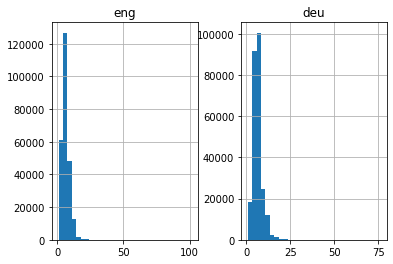

In [ ]:
length_df= pd.DataFrame({'eng': eng_lines, 'deu': ger_lines})
length_df.hist(bins= 30)
plt.show()

In [ ]:
#tokenizer
def tokenization(lines):
  tokenizer= Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#english tokenizer
eng_tokenizer= tokenization(deu_eng[:,0])
eng_vocab_size= len(eng_tokenizer.word_index)+1
eng_length= 8
print('English vocabulary size: %d'%eng_vocab_size)

English vocabulary size: 5398


In [ ]:
#german tokenizer
deu_tokenizer= tokenization(deu_eng[:, 1])
deu_vocab_size= len(deu_tokenizer.word_index) +1
deu_length= 8
print('Deutsch vocabulary size: %d' %deu_vocab_size)

Deutsch vocabulary size: 8737


In [ ]:
#encoding and padding
def encode_sequences(tokenizer, length, lines):
  #integer encode sequences
  seq= tokenizer.texts_to_sequences(lines)
  #pad sequences with 0 values
  seq= pad_sequences(seq, maxlen=length, padding='post')
  return seq

MODEL BUILDING- we split the data in train and testing sections, test size is 0.2, i.e. 80% of the data will be used for training rest for testing


In [ ]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(deu_eng, test_size= 0.2, random_state= 12)


now we encode the sentences. we encode the german sentences as input sequences and english sentences as the target sequences.

In [ ]:
#training data
trainX= encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY= encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
#validation/testing data
testX= encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY= encode_sequences(eng_tokenizer, eng_length, test[:, 0])

now we define our Seq2Seq model architecture, we're using LSTM as our encoder, followed by  a dense layer as a decoder

In [ ]:
#building NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model= Sequential()
  model.add(Embedding(in_vocab, units, input_length= in_timesteps, mask_zero= True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences= True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

we also have to use an optimizer for the model, we'll be using RMSprop optimizer in this model as it's a good choice for RNN. LR is learning rate, high learning rate means smaller time for training then model will not be so accurate so we keep lr a bit lower, still keeping in mind the training time of the model.

In [ ]:
model= build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
#rms= optimizers.RMSprop(learning_rate=0.001)
model.compile( loss='sparse_categorical_crossentropy')

we will train the model at 5 epochs with a batch size of 512

In [ ]:
filename= 'model.mansi'
checkpoint= ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only= True, mode='min')
history= model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1],1),
                   epochs=5, batch_size=512,
                   validation_split= 0.2,
                   callbacks=[checkpoint], verbose= 1)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 3.3420
Epoch 1: val_loss improved from inf to 2.63995, saving model to model.mansi


INFO:tensorflow:Assets written to: model.mansi/assets


INFO:tensorflow:Assets written to: model.mansi/assets


50/50 [==============================] - 214s 4s/step - loss: 3.3420 - val_loss: 2.6400
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 2.6066
Epoch 2: val_loss improved from 2.63995 to 2.55773, saving model to model.mansi


INFO:tensorflow:Assets written to: model.mansi/assets


INFO:tensorflow:Assets written to: model.mansi/assets


50/50 [==============================] - 211s 4s/step - loss: 2.6066 - val_loss: 2.5577
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 2.4876
Epoch 3: val_loss improved from 2.55773 to 2.42600, saving model to model.mansi


INFO:tensorflow:Assets written to: model.mansi/assets


INFO:tensorflow:Assets written to: model.mansi/assets


50/50 [==============================] - 209s 4s/step - loss: 2.4876 - val_loss: 2.4260
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 2.3167
Epoch 4: val_loss improved from 2.42600 to 2.29836, saving model to model.mansi


INFO:tensorflow:Assets written to: model.mansi/assets


INFO:tensorflow:Assets written to: model.mansi/assets


50/50 [==============================] - 209s 4s/step - loss: 2.3167 - val_loss: 2.2984
Epoch 5/5
50/50 [==============================] - ETA: 0s - loss: 2.1745
Epoch 5: val_loss improved from 2.29836 to 2.20577, saving model to model.mansi


INFO:tensorflow:Assets written to: model.mansi/assets


INFO:tensorflow:Assets written to: model.mansi/assets


50/50 [==============================] - 209s 4s/step - loss: 2.1745 - val_loss: 2.2058


the loss reduces from 3.09 to 2.18 with epochs 1 to 5, if we increase the epochs we can decrease the loss even more. now we'll compare the training loss and validation loss

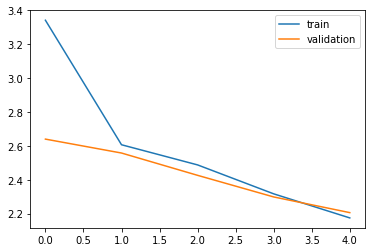

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()


In [ ]:
model= load_model('model.mansi')
preds= model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
    return None

In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t)

       preds_text.append(' '.join(temp))

In [ ]:
pred_df= pd.DataFrame({ 'actual': test[:,0], 'predicted': pred_text})
pd.set_option('display.max_colwidth', 200)
pred.df_head(15)


actual	predicted
0	i know that already	i already know that
1	whos she	who is she
2	do you have it	did you have it
3	use your feet	get your stuff
4	that was the trouble	the
5	he took off his coat	he put off his
6	tom went sightseeing	tom staggered the
7	i tried on the shoes	i answered my shoes
8	open those doors	the window
9	ive got to help tom	i have to help tom
10	its my money	its my money
11	is it time	is it time
12	i cant watch	i cant look in
13	he wants more	he wants to change
14	who did you see	who did you seen